 # Data Loading tutorial

 This notebook demonstrates the structure of the new dataset laytou from
 * https://github.com/PPPLDeepLearning/dataset_D3D_100
 * https://github.com/PPPLDeepLearning/dataset_ELM_full

and how to use to [d3d_loaders](https://github.com/PlasmaControl/d3d_loaders) stage this data for deep learning purposes

d3d_loaders provides torch datasets and samplers interface to operate on a collection of HDF5 files that
are downloaded and pre-processed by the scripts in the dataset repos.

The implementation of this interface closely follows https://pytorch.org/docs/stable/data.html



In [3]:
import h5py

from os.path import join 
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
from time import perf_counter

In [6]:
import torch
from torch.utils.data import DataLoader


In [4]:
import sys
sys.path.append("/home/rkube/repos/d3d_loaders")

In [20]:
from d3d_loaders.time_sampling import sampler_causal, sampler_linearip, sampler_space
from d3d_loaders.standardizers import standardizer_mean_std
from d3d_loaders.d3d_loaders import D3D_dataset
from d3d_loaders.samplers import BatchedSampler, BatchedSampler_multi, collate_fn_batched

In [7]:
# Parameters for data loading
seq_length = 128   # Length of the sequence used to predict the Time-To-Disruption (TTD)
batch_size = 16     

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## First we set up the d3d_loaders infrastructure to instantiate a dataset

In [15]:
# Fetch the dataset definition.
# The dataset was compiled with the code in
# https://github.com/PPPLDeepLearning/dataset_D3D_100
datapath = "/projects/FRNN/dataset_D3D_100/D3D_100"

# fetch dataset definition for list of predictors.
with open(join(datapath, "..", "d3d_100.yaml"), "r") as fp:
    d3d_100 = yaml.safe_load(fp)


shotnr = list(d3d_100["shots"].keys())[0]

In [16]:
# Next we need to instantiate samplers.
# These are used when reading the signal data from HDF5 and resample the raw MDS/PTdata signals
# onto a common time-base
# Each shot has a different length. We therefore create separate re-samplers for each shot
# that will operate on the duration for each specific shot.
#
# The times t_max and t_min have been calculated when the dataset was instantiated.

# Load tmax from yaml
with open(join(datapath, "..", "shots_t_min_max.yaml"), "r") as fp:
    t_min_max_dict = yaml.safe_load(fp)


# The D3D_dataset expects samplers than allow to put all signals, fs07, ipsip, etc, onto
# a common time-base
tmin = t_min_max_dict[shotnr]["tmin"]
tmax = t_min_max_dict[shotnr]["tmax"]
sampler_pred = sampler_causal(tmin, tmax, 1.0, t_shift=0.0)
sampler_targ = sampler_linearip(tmin, tmax, 1.0, t_shift=0.0)


In [17]:
# Signals are to be normalized to a mean and standard deviation that is calculated over all shots
# in the dataset. Again, these have been calculated during dataset instantiation and stored in a yaml file.
# Here we only need to read the results from that file and instantiate a standardizer for each predictor.
  
norm_dict = {}
with open(join(datapath, "..", "normalization.yaml"), "r") as fp:
    normalization = yaml.safe_load(fp)

for k, v in normalization.items():
    norm_dict[k] = standardizer_mean_std(v["mean"], v["std"])
    
# See if normalizers exists for each predictor
for k in d3d_100["predictors"]:
    print(f"{k}: - {norm_dict[k]}")

q95: - standardizer_mean_std, mean=5.039928436279297, std=1.5716230869293213
efsli: - standardizer_mean_std, mean=0.35555943846702576, std=1.857176423072815
ipspr15V: - standardizer_mean_std, mean=0.5942406058311462, std=1.3463371992111206
efsbetan: - standardizer_mean_std, mean=0.5025940537452698, std=2.617089033126831
efswmhd: - standardizer_mean_std, mean=192412.53125, std=336368.1875
dssdenest: - standardizer_mean_std, mean=1.5957257747650146, std=2.1213574409484863
pradcore: - standardizer_mean_std, mean=0.000497624627314508, std=0.0013699629344046116
pradedge: - standardizer_mean_std, mean=0.00027844574651680887, std=0.0006822358118370175
bmspinj: - standardizer_mean_std, mean=2996.464599609375, std=3231.459228515625
bmstinj: - standardizer_mean_std, mean=2.405306577682495, std=2.611988067626953
ipsiptargt: - standardizer_mean_std, mean=1.0042184591293335, std=1.1156623363494873
ipeecoil: - standardizer_mean_std, mean=-0.023169364780187607, std=0.18698279559612274
edensfit: - sta

In [18]:
# Instantiate a sampler for the profiles.
# This will re-sample edensfit and etempfit on psi=[0.0, 1.0] with 32 points

ip_profile = sampler_space(np.linspace(0.0, 1.0, 32, dtype=np.float32))

### Instantiate a data set
The dataset serves like a high-level interface to signals from a single shot.
Internally, it re-samples all signals onto a common time-base, given by `sampler_pred` for the predictors
and `sampler_targ` for the target. The profiles are re-sampled onto common spatial points, defined through `ip_profile`. Data is normalized according to `norm_dict`.

See the code for the D3D_dataset class here: https://github.com/PlasmaControl/d3d_loaders/blob/6c8a068d81be80c47edd30fbafb85cc730636853/d3d_loaders/d3d_loaders.py#L20
The constructor will iterate over the list of predictors passed and builds  a `signal` class for each predictor.


Re-sampling and normalization happens when a `signal` class is instantiated here:
https://github.com/PlasmaControl/d3d_loaders/blob/6c8a068d81be80c47edd30fbafb85cc730636853/d3d_loaders/signal0d.py#L19

In [21]:
# Create a dataset for a single shot. This fetches all signals for all shots from HDF5 files and loads them
# into memory (torch.device("cpu")). Pass the previously instantiated samplers and standardizers
# to resample and normalize the raw signals that are stored in HDF5 files. The data in memory is then
# resampled and normalized.
ds_train = D3D_dataset(shotnr, d3d_100["predictors"], ["ttd"],
                       sampler_pred, sampler_targ, ip_profile, norm_dict, datapath, torch.device("cpu"))
#

### Build a DataLoader
For disruption prediction and ELM prediction we need a ML model to map a sequence of input signal data to
a time-to-disruption or time-to-ELM. That is we map a time series to a scalar
[x_0, x_1,...., x_N] -> TTD

Here N is the sequence length, which correcposnds to the variable `seq_length` in this notebook.

Here the x_0, x_1, etc are just the samples of all predictor signals stacked on top of each other:

x_0 = [q95_0, efsli_0, ... edensfit_0, etempfit_0]. The order corresposnds to `d3d_100["predictors"]`

That is our model maps

model([x_0, ..., x_N]) = TTD_{N+_1}

In the notebook here, we map a sequence of 128 samples to the TTD that immediately follows that sequence.


The DataLoaders allow us to sample these sequences from the data set.








In [23]:
# The ds_train dataset serves as an interface to pull data from the collection of HDF5 files
# that are stored on disk.
#
# To access samples of sequences from the signal data we use a DataLoader


# The sampler defines the length, batch_size, and order of the sequences we sample
# seq_length: Length of the data time series
# batch_size: number of independent sequences we get from the HDF5 files
# shuffle: True means all sequences start at a random point. False means the sequences will be sampled in
# order when iterating over the data loader
sampler_train = BatchedSampler(len(ds_train), seq_length, batch_size, shuffle=False)

loader_train = DataLoader(ds_train,
                         batch_sampler=sampler_train, 
                         collate_fn=collate_fn_batched())

In [26]:
# Now that we have a data loader, we can get the first sample
x, y = next(iter(loader_train))

print(x.shape, y.shape)

torch.Size([129, 16, 76]) torch.Size([129, 16, 1])


The cell above shows that when we iterate ove the dataloader, we get samples x with shape = (129, 16, 76).

The first dimension has size 129=seq_length+1. This is the time dimension. That is x[0, 0, :] = 
[q95_0, efsli_0, ..., etempfit_0], which are the individual predictor time series stacked on top of each other.


The second dimension has size 16. This is the batch dimension. Since we set shuffle=False when instantiating BatchedSampler, the sequences are shifted only by a single index


The third dimension has size 76. This is the dimension of the number of channels per time series.
Predictors like q95, efsli, etc. are all scalar time series. These are of type `signal_0d`:
https://github.com/PlasmaControl/d3d_loaders/blob/main/d3d_loaders/signal0d.py

Predictors like edensfit, etempfit are profiles. These are of type `signal_1d`:
https://github.com/PlasmaControl/d3d_loaders/blob/main/d3d_loaders/signal1d.py
Profiles are functions of both time and space. They are considered 1d time series

In [32]:
# This shows that dimemsion 1 is the batch dimension.
# Taking the first 10 samples in batch1 is the same as taking samples 1 through 11 in batch 0.
# That is, each batch is shifted by 1.
# This behaviour is useful for inference, when we ask the model to re-construct the TTD time series
# for an entire shot. We would just have to iterate a BatchedSampler with shuffle=False and iterate
# the dataloader over all samples to get this re-construction


# Batch 1 is shifted by 1 sample w.r.t. batch 0
print((x[0:10, 1, :] == x[1:11, 0, :]).all())
# Batch 2 is shifted by 2 sample w.r.t. batch 0
print((x[0:10, 2, :] == x[2:12, 0, :]).all())

tensor(True)
tensor(True)


Next, we should be able to match values in x to values in the HDF5 files.


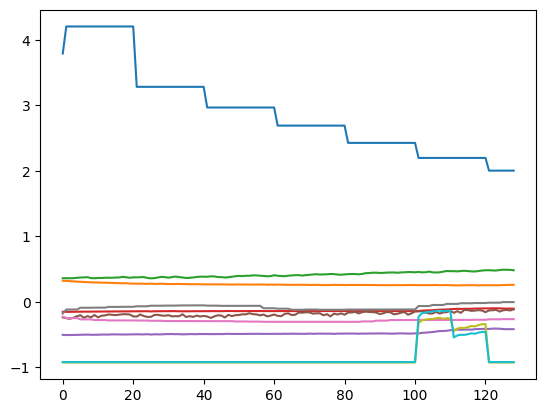

In [53]:
# Let's plot the first predictor in the dataset
plt.plot(x[:, 0, :10])

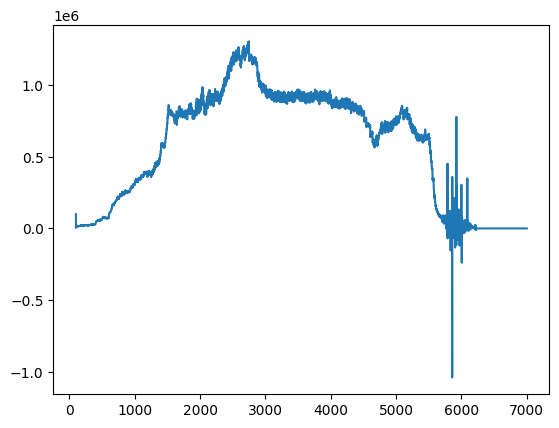

In [67]:
# In this cell we have to find the corresponding predictor in the HDF5 file.
# We should be able to get the same plot as above


# Signals in the dataset are normalized, see https://github.com/PlasmaControl/d3d_loaders/blob/6c8a068d81be80c47edd30fbafb85cc730636853/d3d_loaders/signal0d.py#L45
# We can use the information from the standardizer to reverse this normalization.
# hat(x) is the normalized signal in the `signal_q95` class. x is the raw data inthe HDF5 file
# hat(x) = (x - mean(x)) / std(x)
# => x = hat(x) * std(x) + mean(x)
#q95_mean = ds_train.predictors["q95"].standardizer.mean
#q95_std = ds_train.predictors["q95"].standardizer.std

with h5py.File(join(datapath,  f"{shotnr}.h5"), "r") as fp:
    tb = fp["/efswmhd/xdata"][:]
    q95 = fp["/efswmhd/zdata"][:]


plt.plot(tb, q95)

#q95 = (q95 * q95_std) - q95_mean

#good_tidx = (tb > 0.0) & (tb < 130)

#plt.plot(tb[good_tidx], q95[good_tidx])
    

In [51]:
d3d_100["predictors"]

['q95',
 'efsli',
 'ipspr15V',
 'efsbetan',
 'efswmhd',
 'dssdenest',
 'pradcore',
 'pradedge',
 'bmspinj',
 'bmstinj',
 'ipsiptargt',
 'ipeecoil',
 'edensfit',
 'etempfit']

In [48]:
mean = ds_train.predictors["q95"].standardizer.mean
std = ds_train.predictors["q95"].standardizer.std